In [1]:
import os
import tempfile
from urllib.parse import urlparse

import matplotlib.pyplot as plt
# import planetary_computer
# import pystac
import torch
from torch.utils.data import DataLoader

from torchgeo.datasets import RasterDataset, stack_samples, unbind_samples
from torchgeo.datasets.utils import download_url
from torchgeo.samplers import RandomGeoSampler

In [2]:
class IceVelocity_u(RasterDataset):
    filename_glob = 'ice_velocity_u_*.tif'
    # filename_regex = r'^.{6}_(?P<date>\d{8}T\d{6})_(?P<band>B0[\d])'
    # date_format = '%Y%m%dT%H%M%S'
    is_image = True
    # separate_files = True
    all_bands = ('1')
    # rgb_bands = ('B04', 'B03', 'B02')

    def plot(self, sample):
        image = sample['image'][0]
        image = torch.clamp(image / 10000, min=0, max=1).numpy()
        fig, ax = plt.subplots()
        ax.imshow(image)
        return fig
    
    def plot_rgb(self, sample):
        # Find the correct band index order
        rgb_indices = []
        for band in self.rgb_bands:
            rgb_indices.append(self.all_bands.index(band))
        image = sample['image'][rgb_indices].permute(1, 2, 0)
        image = torch.clamp(image / 10000, min=0, max=1).numpy()
        fig, ax = plt.subplots()
        ax.imshow(image)

        return fig
    
class IceVelocity_v(RasterDataset):
    filename_glob = 'ice_velocity_v_*.tif'
    # filename_regex = r'^.{6}_(?P<date>\d{8}T\d{6})_(?P<band>B0[\d])'
    # date_format = '%Y%m%dT%H%M%S'
    is_image = True
    # separate_files = True
    all_bands = ('1')
    # rgb_bands = ('B04', 'B03', 'B02')

class Calving(RasterDataset):
    filename_glob = '*.tif'
    # filename_regex = r'^.{6}_(?P<date>\d{8}T\d{6})_(?P<band>B0[\d])'
    # date_format = '%Y%m%dT%H%M%S'
    is_image = False
    # separate_files = True
    all_bands = ('1')
    # rgb_bands = ('B04', 'B03', 'B02')

In [3]:
ivu_root = '/home/hamze/mnt/experiment-3/AI4IS/data/gtiff_200m/ice_velocity_u/'
ivu = IceVelocity_u(ivu_root)
ivv_root = '/home/hamze/mnt/experiment-3/AI4IS/data/gtiff_200m/ice_velocity_v/'
ivv = IceVelocity_v(ivv_root)
calving_root = '/home/hamze/mnt/experiment-3/AI4IS/data/calving/'
calving = Calving(calving_root)

# g = torch.Generator().manual_seed(1)
# sampler = RandomGeoSampler(ivu, size=200, length=3, generator=g)
# dataloader = DataLoader(ivu, sampler=sampler, collate_fn=stack_samples)

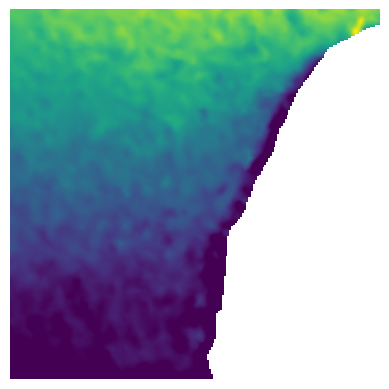

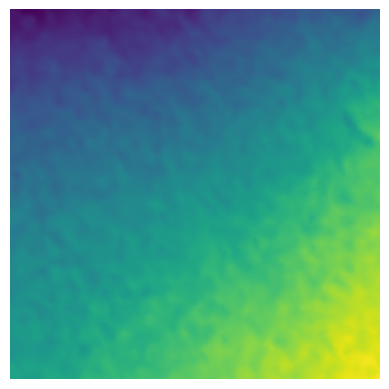

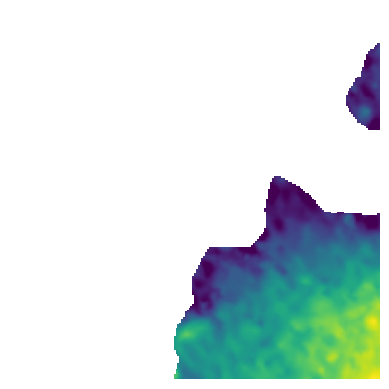

In [ ]:
for batch in dataloader:
    sample = unbind_samples(batch)[0]
    ivu.plot(sample)
    plt.axis('off')
    plt.show()

In [4]:
from lightning.pytorch import Trainer
import timm
from torchgeo.models import ResNet50_Weights
from torchgeo.trainers import SemanticSegmentationTask

/home/hamze/anaconda3/envs/ais/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
weights = ResNet50_Weights.SENTINEL1_GRD_MOCO
task = SemanticSegmentationTask(model='unet', backbone='resnet50', weights=weights, in_channels=2, task='binary', num_classes=None, num_labels=None, num_filters=3, loss='focal', class_weights=None, ignore_index=None, lr=0.001, patience=10, freeze_backbone=False, freeze_decoder=False)

In [ ]:
# in_chans = weights.meta['in_chans']
# model = timm.create_model('resnet50', in_chans=in_chans, num_classes=10)
# model.load_state_dict(weights.get_state_dict(progress=True), strict=False)

In [7]:
iv = ivu & ivv
combined_dataset = iv & calving

# # Use the same sampler, but on the combined dataset
# sampler = RandomGeoSampler(combined_dataset, size=200, length=3, generator=g)
# dataloader = DataLoader(combined_dataset, sampler=sampler, collate_fn=stack_samples)

1


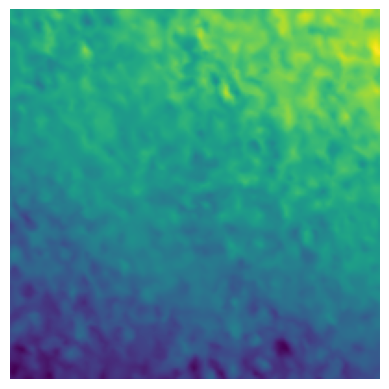

1


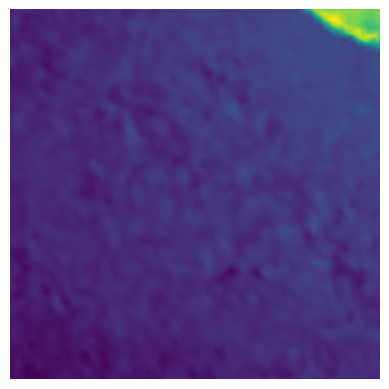

1


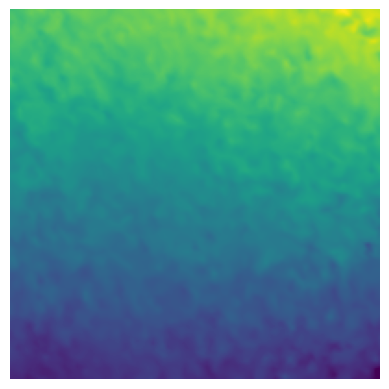

In [7]:
for batch in dataloader:
    sample = unbind_samples(batch)
    image = sample[0]['image']
    image_first = image[0]
    image_first = torch.clamp(image_first / 10000, min=0, max=1).numpy()
    fig, ax = plt.subplots()
    ax.imshow(image_first)
    plt.axis('off')
    plt.show()

In [8]:
# %load_ext tensorboard
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger

In [10]:
batch_size = 1
num_workers = 2
max_epochs = 5
fast_dev_run = False

In [11]:
# default_root_dir = os.path.join(tempfile.gettempdir(), 'experiments')
default_root_dir = '.'
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss', dirpath=default_root_dir, save_top_k=1, save_last=True
)
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=10)
logger = TensorBoardLogger(save_dir=default_root_dir, name='tutorial_logs')

trainer = Trainer(
    callbacks=[checkpoint_callback, early_stopping_callback],
    fast_dev_run=fast_dev_run,
    log_every_n_steps=1,
    logger=logger,
    min_epochs=1,
    max_epochs=max_epochs,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [12]:
from custom_geo_data_module import CustomGeoDataModule as gdm
# Create the datamodule with your existing dataset
datamodule = gdm(
    dataset=combined_dataset,  # Pass the initialized dataset
    batch_size=32,
    patch_size=(256, 256),
    length=1000,  # samples per epoch
    num_workers=4,
    split_ratios=(0.7, 0.2, 0.1),  # Custom train/val/test splits
    seed=42  # For reproducibility
)

# Setup (called automatically by Lightning if using Trainer)
datamodule.setup("fit")  # For training



In [ ]:
# # Get dataloaders
# train_loader = datamodule.train_dataloader()
# val_loader = datamodule.val_dataloader()

# Or use with Lightning
trainer.fit(task, datamodule=datamodule)

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.demos import LightningMNISTClassifier
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import MNIST
from torchvision import transforms

# 1. Define your LightningModule
model = LightningMNISTClassifier()

# 2. Define your data (e.g., using a LightningDataModule or DataLoaders)
transform = transforms.ToTensor()
mnist_full = MNIST(root="./data", train=True, download=True, transform=transform)
train_size = int(0.8 * len(mnist_full))
val_size = len(mnist_full) - train_size
mnist_train, mnist_val = random_split(mnist_full, [train_size, val_size])

train_loader = DataLoader(mnist_train, batch_size=32)
val_loader = DataLoader(mnist_val, batch_size=32)

# 3. Initialize the Trainer
trainer = pl.Trainer(max_epochs=10)

# 4. Call trainer.fit() to start training
trainer.fit(model, train_loader, val_loader)